### Подключение библиотек

In [3]:
#pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
import catboost
import pickle as pkl

import json
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import *
from pprint import pprint
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.tree import *

### Обучение и выполнение лучшей модели

In [4]:
# Путь к тренировочному набору
path_train =  "train.csv"
# Путь к тестовому набору
path_test  =  "test.csv"

In [5]:
data = pd.read_csv(path_train)

In [6]:
data["Mileage"] = data["Mileage"].apply(lambda value: int(re.findall(r'\d+', value)[0]))
data["is_turbo"] = data["Engine_volume"].apply(lambda value: int("Turbo" in value))
data["Engine_volume"] = data["Engine_volume"].apply(lambda value: float(re.findall(r'\d*\.\d+|\d+', value)[0]))

In [7]:
categorical_features = ['Brand', 'Model', 'Year_of_production', 'Type',
                        'Leather_interior', 'Fuel_type',
                        'Cylinders', 'Gear_box', 'Drive_wheels', 'Doors', 'Color', 'Airbags']


In [8]:
data

,ID,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price,is_turbo
0,45774636,OPEL,Combo,2003,Goods wagon,No,Diesel,1.7,152000,4.0,Manual,Front,04-May,Grey,2,1438,9408,0
1,45787352,MERCEDES-BENZ,Vito,2008,Minivan,No,Diesel,2.2,198700,4.0,Manual,Rear,02-Mar,White,6,1195,17000,1
2,45393419,TOYOTA,CHR,2018,Jeep,No,Petrol,2.0,37214,4.0,Automatic,Front,04-May,Grey,10,1079,36065,0
3,45802407,HYUNDAI,Grandeur,2012,Sedan,Yes,Petrol,3.0,137235,4.0,Automatic,Front,04-May,Silver,4,919,15524,0
4,45647870,MERCEDES-BENZ,ML 350,2015,Jeep,Yes,Diesel,3.5,79080,6.0,Automatic,4x4,04-May,Grey,12,1273,22894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7231,45768179,LEXUS,CT 200h,2014,Hatchback,Yes,Hybrid,1.8,132563,4.0,Automatic,Front,04-May,Red,0,308,11447,0
7232,45621866,HYUNDAI,Sonata,2014,Sedan,No,Petrol,2.4,148800,4.0,Tiptronic,Front,04-May,Black,6,749,18503,0
7233,45732832,HYUNDAI,Sonata,2015,Sedan,Yes,LPG,2.0,283895,4.0,Automatic,Front,04-May,Silver,4,765,15367,0
7234,45802992,HYUNDAI,Santa FE,2010,Jeep,Yes,Diesel,2.0,229398,4.0,Automatic,Front,04-May,Black,4,836,19008,0


In [9]:
X = data.drop(["Price", "ID"], axis=1)
Y = data["Price"]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, random_state = 42)

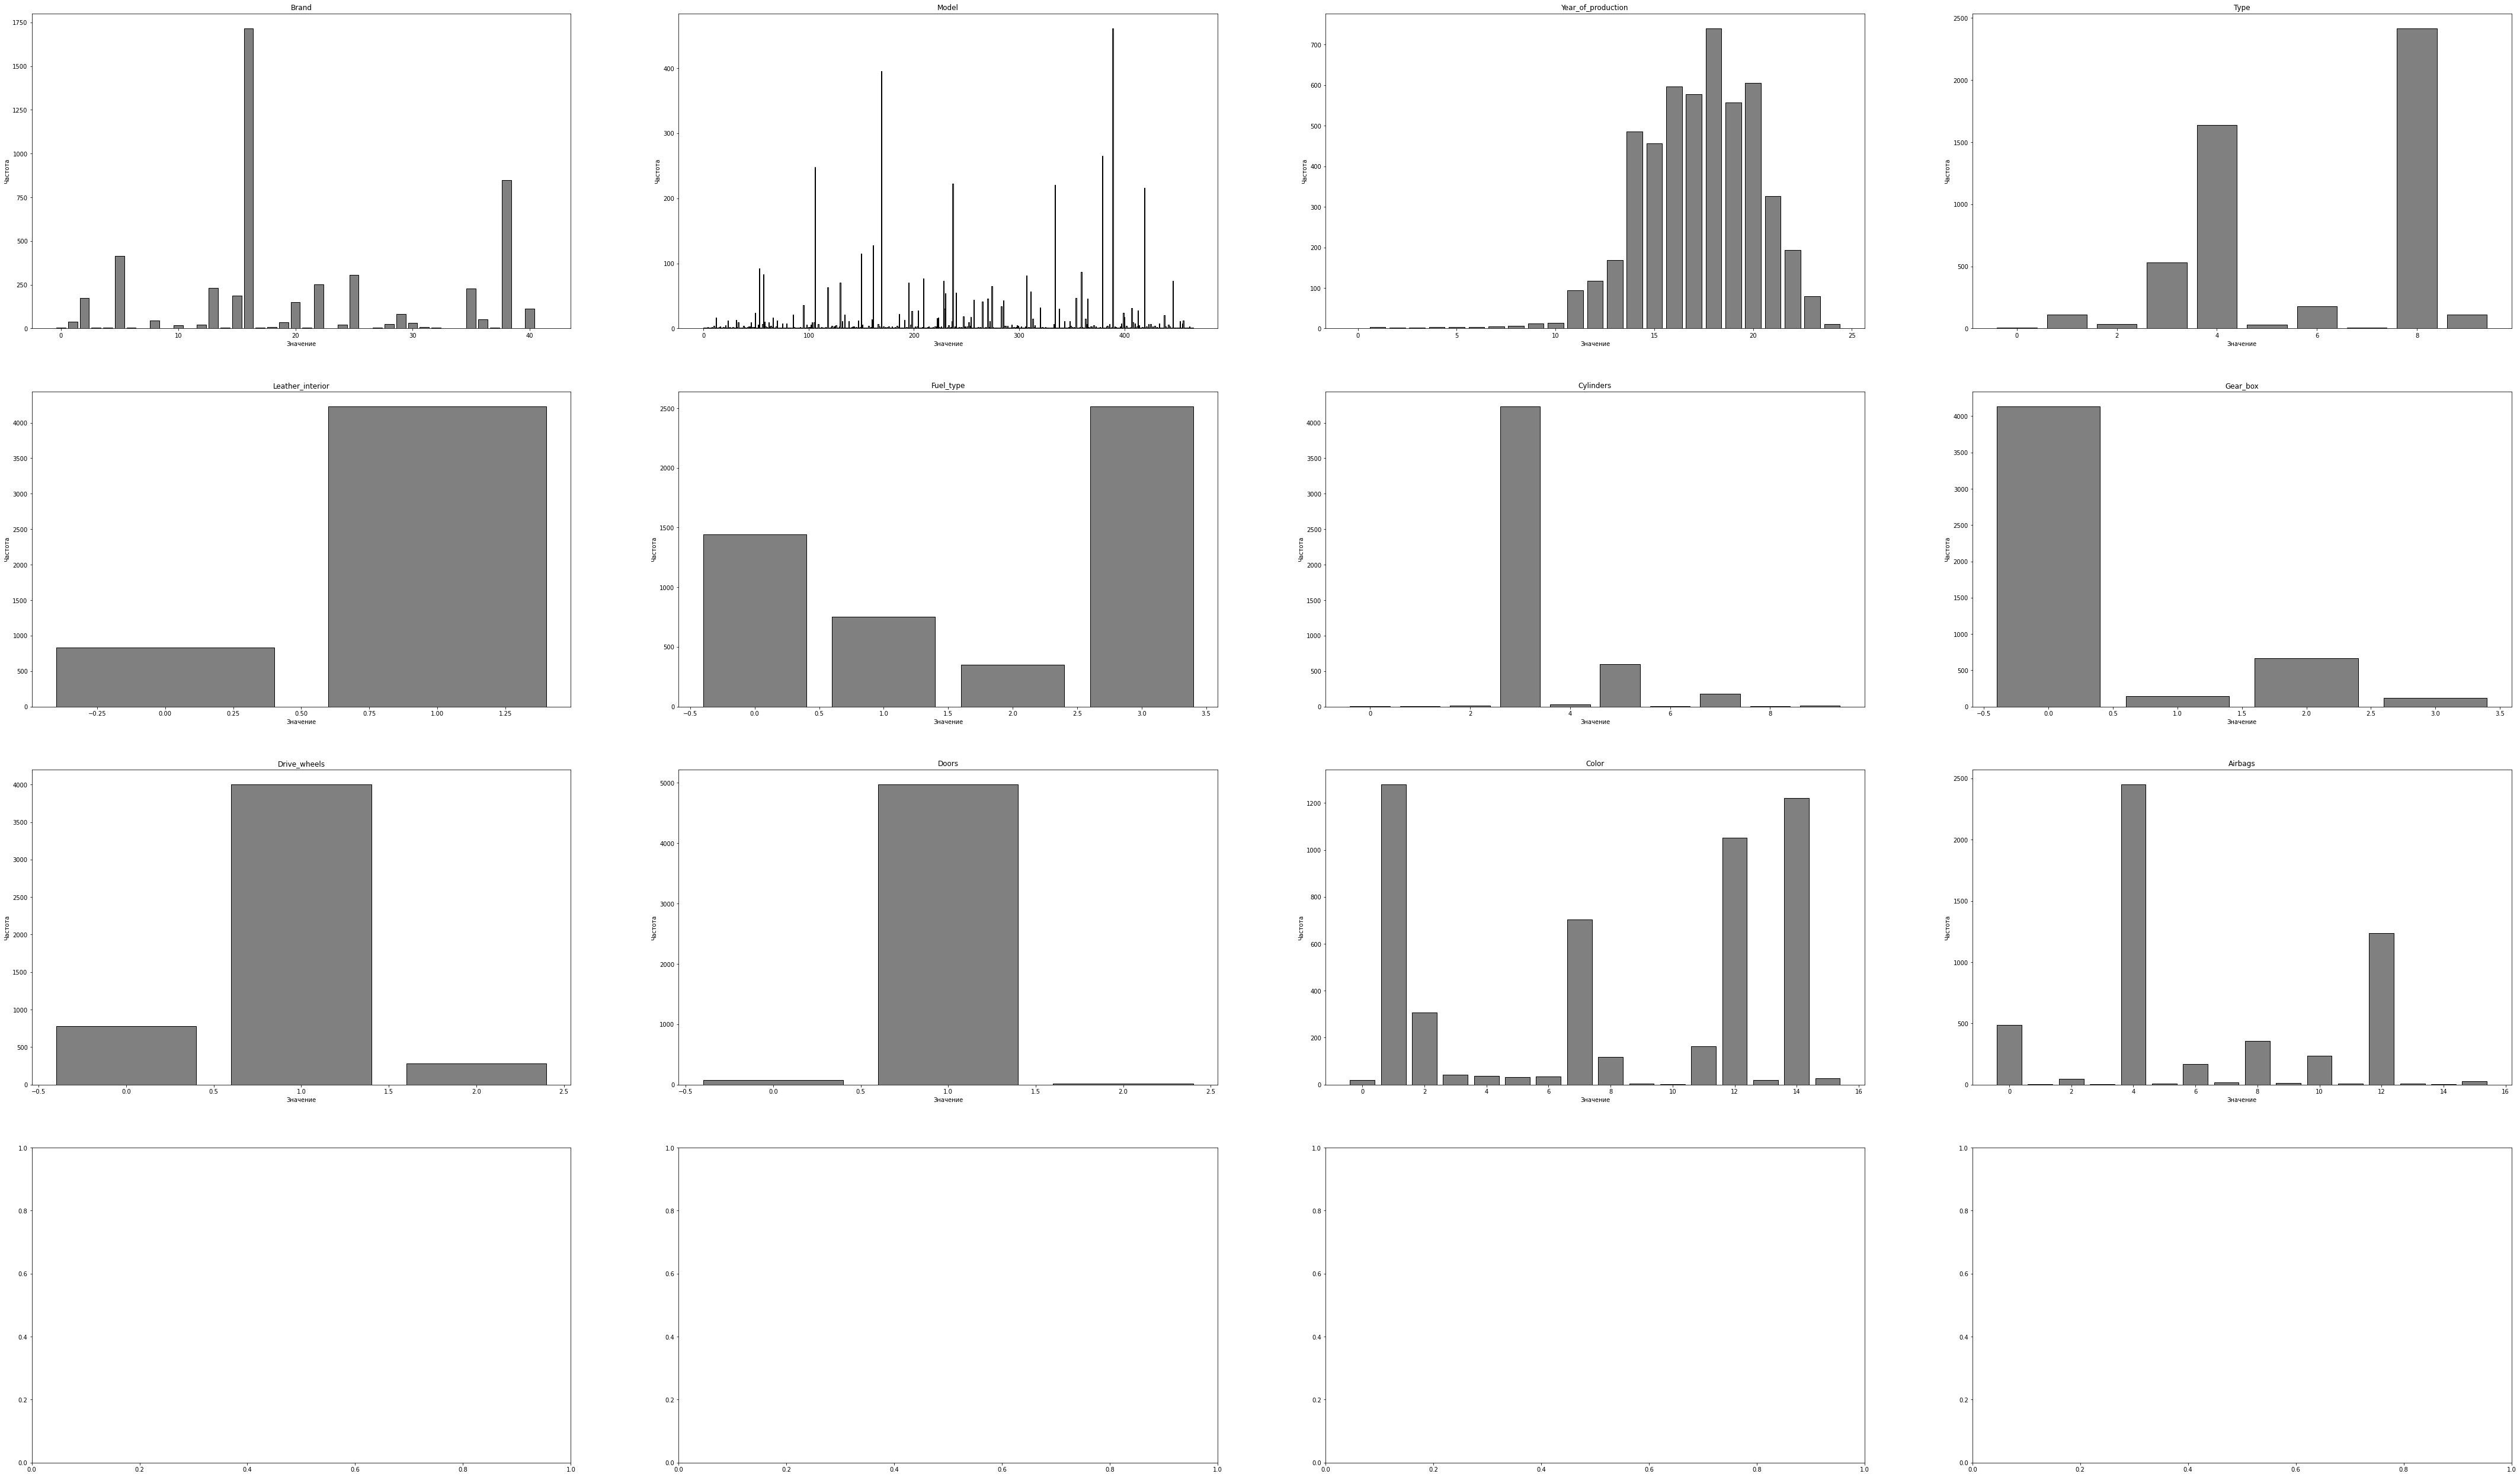

In [12]:
fig, axs = plt.subplots(nrows= 4 , ncols= 4 )

fig.set_figheight(45)
fig.set_figwidth(75)

le = LabelEncoder()

for i in range(len(categorical_features)):
    current_feature = categorical_features[i]
    le.fit(x_train[current_feature])
    bins = np.bincount(le.transform(x_train[current_feature]))
    
    axs[i // 4, i % 4].set_title(current_feature)
    axs[i // 4, i % 4].bar(range(len(bins)), bins, color='gray', edgecolor='black')
    axs[i // 4, i % 4].set_ylabel("Частота")
    axs[i // 4, i % 4].set_xlabel("Значение")

In [13]:
def anomalies_report(anomalies):
    return print("Аномалий: {}\nПроцент аномалий:   {:.2f}%".format(sum(anomalies), 100*np.mean(anomalies))) 

scale_features = ["Mileage", "Tax", "Engine_volume"]
scaler = RobustScaler()

x_train[scale_features] = scaler.fit_transform(x_train[scale_features])

with open("robustscaler.pkl", 'wb') as f:
    pkl.dump(scaler, f)
    
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, 
                                   contamination=0.1, 
                                  )

isolation_forest.fit(x_train[scale_features].values)

isolation_predict = isolation_forest.predict(x_train[scale_features].values)
anomalies = np.where(isolation_predict < 0, True, False)
anomalies_report(anomalies)

Аномалий: 506
Процент аномалий:   9.99%


In [14]:
x_train = x_train.drop(x_train[anomalies].index, axis=0)
y_train = y_train.drop(y_train[anomalies].index, axis=0)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index (drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index (drop=True, inplace=True)

In [15]:
def create_target_feature_encoding(X, Y, features):
  features_values_targets = {}
  
  for feature in features:
    features_values_targets[feature] = {}
    for value in set(X[feature]):
      features_values_targets[feature][value] = np.mean(Y[X[feature] == value])

  return features_values_targets

In [16]:
x_train

,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,is_turbo
0,HYUNDAI,Sonata,2014,Sedan,Yes,Petrol,0.000000,0.181189,4.0,Automatic,Front,04-May,Silver,10,-0.366048,0
1,NISSAN,Kicks,2018,Jeep,No,Petrol,-0.571429,-1.074894,4.0,Automatic,Front,04-May,Grey,0,0.273210,0
2,CHEVROLET,Cruze Premier,2016,Sedan,Yes,Petrol,-0.714286,0.014832,4.0,Automatic,Front,04-May,Black,8,-0.230769,1
3,MERCEDES-BENZ,E 350,2011,Sedan,Yes,Diesel,1.428571,1.624647,6.0,Automatic,Rear,04-May,White,12,0.639257,0
4,LEXUS,RX 450,2011,Jeep,Yes,Hybrid,2.142857,-0.214921,6.0,Automatic,4x4,04-May,Silver,12,1.047745,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4554,JEEP,Compass,2014,Jeep,Yes,Petrol,0.571429,-0.271016,4.0,Automatic,Front,04-May,Black,4,-0.074271,0
4555,BMW,328,2012,Sedan,Yes,Petrol,0.000000,0.308794,4.0,Automatic,Rear,04-May,Black,12,-0.358090,0
4556,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,0.000000,0.639550,4.0,Automatic,Front,04-May,White,4,0.302387,0
4557,HYUNDAI,Elantra,2015,Sedan,Yes,Petrol,-0.571429,0.240769,4.0,Automatic,Front,04-May,White,4,-0.392573,0


In [17]:
features_values_targets = create_target_feature_encoding(x_train, y_train, categorical_features)

with open("features_values_targets.json", "w") as f: 
  json.dump(features_values_targets, f)
  
for feature in categorical_features:
  x_train[feature] = x_train[feature].replace(features_values_targets[feature])
  x_test[feature]  = x_test [feature].replace(features_values_targets[feature])


default_values = dict(x_train[categorical_features].median())
default_values.update(x_train[set(x_train.columns) - set(categorical_features)].mean())

with open("default_values.json", 'w') as f:
  json.dump(default_values, f)
  
x_train = x_train.fillna(default_values)
x_test  = x_test. fillna(default_values)

/tmp/ipykernel_8145/3308836229.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  default_values.update(x_train[set(x_train.columns) - set(categorical_features)].mean())


In [19]:
power_features = ["Brand", "Model", "Airbags"]
pt = PowerTransformer(method='box-cox')

transformed = pt.fit_transform(x_train[power_features] + 1)

with open("powertransformer.pkl", "wb") as f:
  pkl.dump(pt, f)
  
x_train[power_features] = transformed 

In [20]:
for feature in power_features:
  x_test[feature] = x_test[feature].apply(lambda value: value if type(value) == np.float64 else 1)

x_test[power_features] = pt.transform(x_test[power_features] + 1)

x_test[scale_features] = scaler.transform(x_test[scale_features])

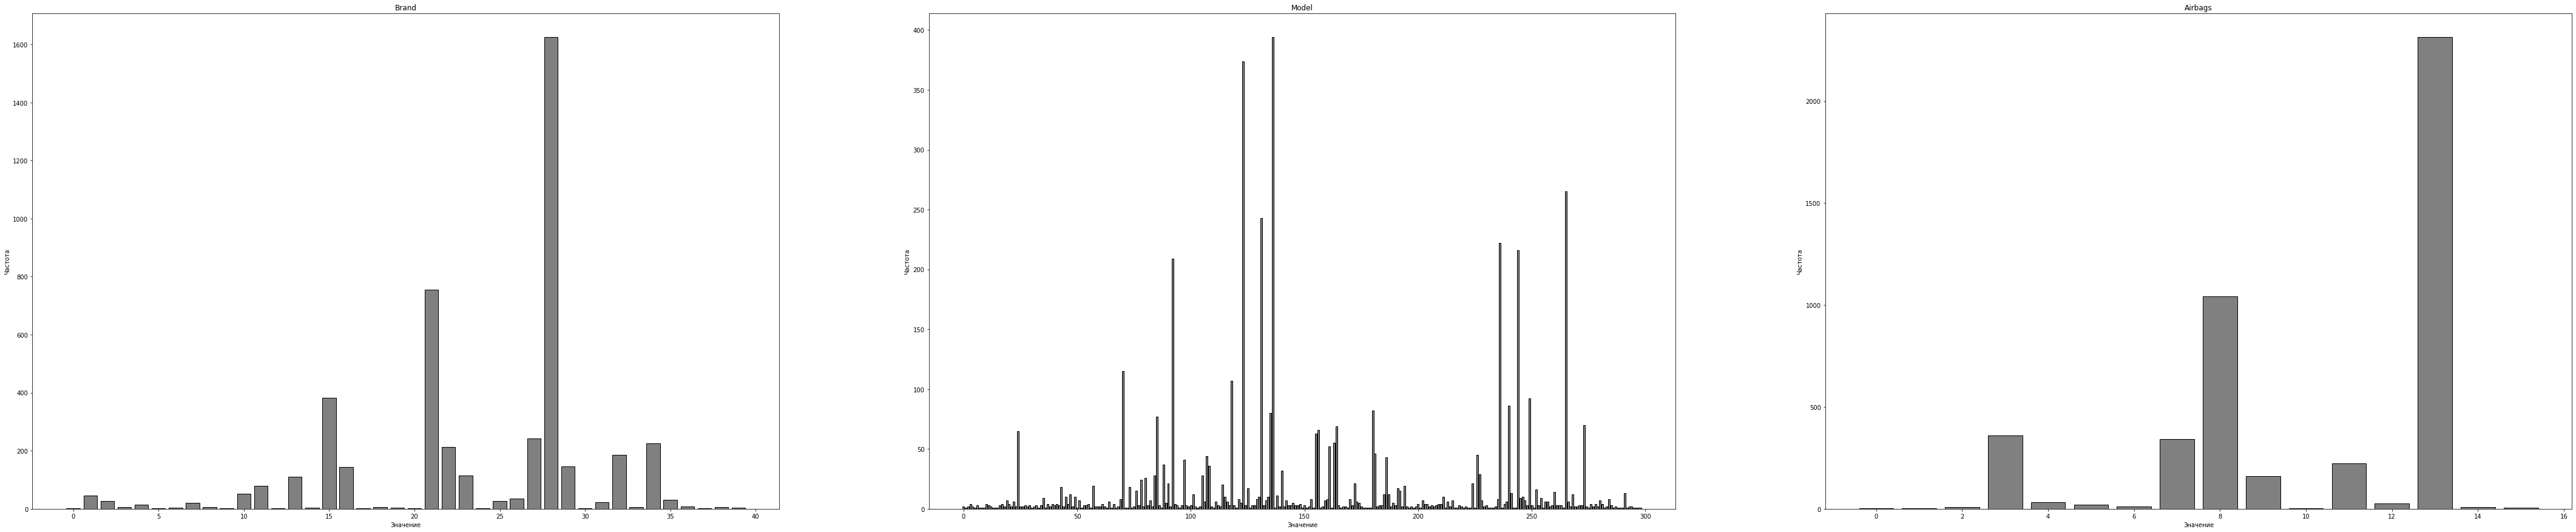

In [21]:
fig, axs = plt.subplots(ncols= len(power_features))

fig.set_figheight(15)
fig.set_figwidth(75)

le = LabelEncoder()

for j in range(len(power_features)):
  current_feature = power_features[j]
  le.fit(x_train[current_feature])
  bins = np.bincount(le.transform(x_train[current_feature]))
    
  axs[j].set_title(current_feature)
  axs[j].bar(range(len(bins)), bins, color='gray', edgecolor='black')
  axs[j].set_ylabel("Частота")
  axs[j].set_xlabel("Значение")

<AxesSubplot:>

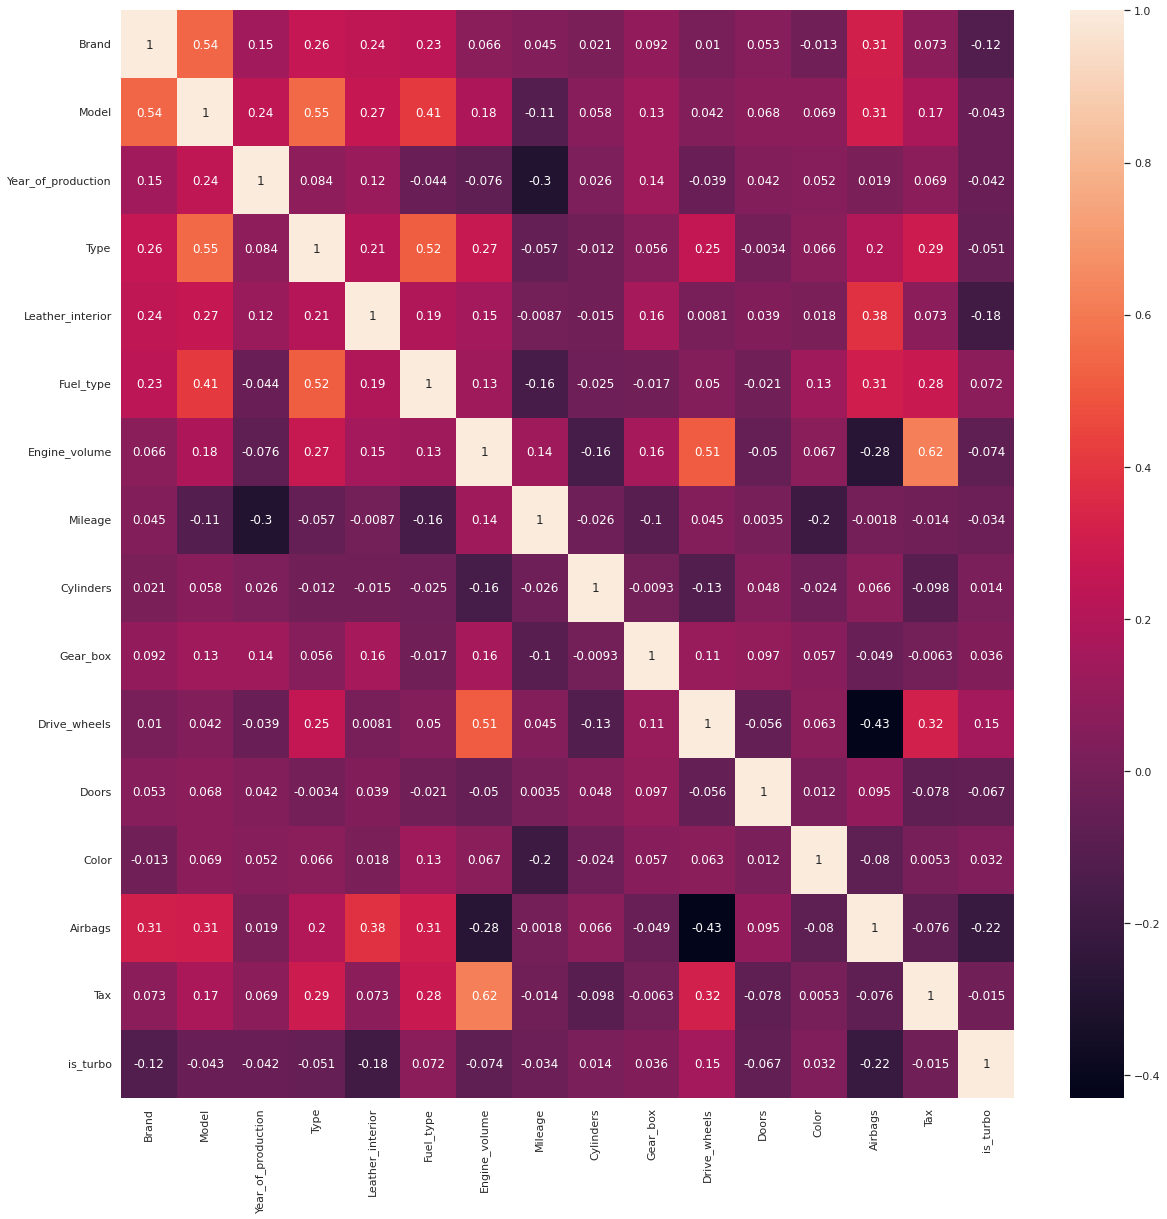

In [22]:
sns.set(rc={'figure.figsize':(20, 20)})

sns.heatmap(x_train.corr(), annot = True)

In [23]:
binging_features = ['Year_of_production', 'Leather_interior',
       'Engine_volume', 'Mileage', 'Cylinders', 'Tax', 'is_turbo']

poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(x_train[binging_features])

with open("polynomical.pkl", "wb") as f:
  pkl.dump(poly, f)
  
X_poly = pd.DataFrame(poly.transform(x_train[binging_features]))

x_train = x_train.drop(binging_features, axis=1)
x_train = pd.concat([x_train, X_poly], axis=1)

In [24]:
X_poly = pd.DataFrame(poly.transform(x_test[binging_features]))

x_test = x_test.drop(binging_features, axis=1)
x_test = pd.concat([x_test, X_poly], axis=1)

In [25]:
pca = PCA(int(x_train.shape[1] * 0.8))
x_train = pca.fit_transform(x_train)

with open("pca.pkl", 'wb') as f:
  pkl.dump(pca, f)

x_test  = pca.transform(x_test) 

/home/yashamov/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/yashamov/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42),
             n_features_to_select=int(x_train.shape[1] * 0.8))

rfe.fit(x_train, y_train)

with open("rfe.pkl", 'wb') as f:
  pkl.dump(rfe, f)

In [ ]:
mask = rfe.get_support()
col_indexes = [i for i in range(mask.shape[0]) if mask[i] == True]
x_train = x_train[:, col_indexes]
x_test  = x_test [:, col_indexes]

In [ ]:
def print_metrics(targets, preds):
  print("MAE : ", mean_absolute_error(targets, preds))
  print("MSE : ", mean_squared_error(targets, preds))
  print("R2 : ", r2_score(targets, preds))

In [ ]:
lin_reg = LinearRegression(42)

lin_reg.fit(x_train, y_train)

lin_reg_preds = lin_reg.predict(x_test)
print_metrics(y_test, lin_reg_preds)

In [ ]:
cv = KFold(n_splits=2, random_state=0, shuffle = True)

In [ ]:
knn = KNeighborsRegressor()

parameters_grid = {
    "n_neighbors" : [3, 7, 9],
    "metric"  : ["euclidean", "manhattan", "minkowski"]
}

grid_cv_knn = GridSearchCV(knn, parameters_grid, scoring='neg_mean_absolute_error', cv = cv)
grid_cv_knn.fit(x_train, y_train)

knn_preds = grid_cv_knn.predict(x_test)
print_metrics(y_test, knn_preds)

In [ ]:
forest = RandomForestRegressor(random_state=0)

parameters_grid = {
     'max_depth'        : [50, 70, 90],
     'n_estimators'     : [500, 700]
     }


grid_cv_forest = GridSearchCV(forest, parameters_grid, scoring='neg_mean_absolute_error', cv = cv)
grid_cv_forest.fit(x_train, y_train)

forest_preds = grid_cv_forest.predict(x_test)
print_metrics(y_test, forest_preds)

In [ ]:
cat = catboost.CatBoostRegressor(logging_level = "Silent")

grid = {
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [3, 5, 7, 9]
        }

grid_cv_catboost = GridSearchCV(estimator = cat, param_grid = grid)

grid_cv_catboost.fit(x_train, y_train)

catboost_preds = grid_cv_catboost.predict(x_test)
print_metrics(y_test, catboost_preds)

In [ ]:
grid_cv_catboost.best_params_

In [ ]:
with open("model.pkl", 'wb') as f:
  pkl.dump(grid_cv_knn, f)

# Test

In [ ]:
path_test = "test.csv"

In [ ]:
data = pd.read_csv(path_test)

In [ ]:
test_data = data

In [ ]:
test_data["Mileage"] = test_data["Mileage"].apply(lambda value: int(re.findall(r'\d+', value)[0]))
test_data["is_turbo"] = test_data["Engine_volume"].apply(lambda value: int("Turbo" in value))
test_data["Engine_volume"] = test_data["Engine_volume"].apply(lambda value: float(re.findall(r'\d*\.\d+|\d+', value)[0]))

test_data = test_data.drop(["ID"], axis=1)

In [ ]:
categorical_features = ['Brand', 'Model', 'Year_of_production', 'Type',
                        'Leather_interior', 'Fuel_type',
                        'Cylinders', 'Gear_box', 'Drive_wheels', 'Doors', 'Color', 'Airbags']
power_features = ["Brand", "Model", "Airbags"]
scale_features = ["Mileage", "Tax", "Engine_volume"]
binging_features = ['Year_of_production', 'Leather_interior',
       'Engine_volume', 'Mileage', 'Cylinders', 'Tax', 'is_turbo']

In [ ]:
with open("features_values_targets.json", 'r') as f:
  features_values_targets = json.load(f)

with open("default_values.json", 'r') as f:
  default_values = json.load(f)

with open("powertransformer.pkl", 'rb') as f:
  pt = pkl.load(f)

with open("robustscaler.pkl", 'rb') as f:
  scaler = pkl.load(f)

with open("polynomical.pkl", 'rb') as f:
  poly = pkl.load(f)

with open("pca.pkl", 'rb') as f:
  pca = pkl.load(f)

with open("rfe.pkl", 'rb') as f:
  rfe = pkl.load(f)

with open("model.pkl", 'rb') as f:
  model = pkl.load(f)

In [ ]:
for feature in categorical_features:
  test_data[feature]  = test_data[feature].replace(features_values_targets[feature])

test_data = test_data.fillna(default_values)

In [ ]:
for feature in power_features:
  test_data[feature] = test_data[feature].apply(lambda value: value if type(value) == np.float64 else 1)

test_data[power_features] = pt.transform(test_data[power_features] + 1)

test_data[scale_features] = scaler.transform(test_data[scale_features])

In [ ]:
X_poly = pd.DataFrame(poly.transform(test_data[binging_features]))

test_data = test_data.drop(binging_features, axis=1)
test_data = pd.concat([test_data, X_poly], axis=1)

In [ ]:
test_data  = pca.transform(test_data) 

In [ ]:
mask = rfe.get_support()
col_indexes = [i for i in range(mask.shape[0]) if mask[i] == True]
test_data  = test_data [:, col_indexes]

In [ ]:
test_data = pd.DataFrame(test_data)

In [ ]:
test_data

In [ ]:
# Маска отобраных номеров строк для предсказания из тестового набора
mask = test_data.index

# Название вектора предсказанных значений  y_predict полученого на основании тестового набора
y_predict = model.predict(test_data.loc[mask])
